This notebook shows how to train an unsupervised CNN. 

In [1]:
using Flux, FFTW, Distributions, Plots, SpecialPolynomials, BenchmarkTools
using BSON: @save
include("./data_generation.jl")
include("./utility_functions.jl")

GSA (generic function with 1 method)

In [6]:
# Some global variables.
const nfft = 100    # Grid size
m = 100000     # Number of data points
ft = plan_fft(zeros((nfft,)),flags=FFTW.MEASURE)    # Fourier transform
ift = plan_ifft(zeros((nfft,)),flags=FFTW.MEASURE)  # Inverse Fourier transform
const D = DFTcentered(nfft);   # DFT matrix

In [3]:
#----------------------------------------------------------------------
# Dataset generators

function supervised_dataset(N::Integer,m::Integer)
    # N is grid size, m is number of data points
    field_amps = [randomHGAmplitude(nfft) for i=1:m]
    y_data = [randomConvexPhase(nfft,Cauchy(0,(10^(-0.5-rand()) * pi/nfft))) for i=1:m]
    fft_amps = [abs.(ft*(field_amps[i] .* exp.(im*2*pi*y_data[i]))) for i=1:m]
    x_data_formatted = hcat((vcat(field_amps[i],fft_amps[i]) for i=1:m)...)
    y_data_formatted = hcat(y_data...)
    return x_data_formatted, y_data_formatted
end

function unsupervised_dataset(N::Integer,m::Integer)
    # N is grid size, m is number of data points
    slm_amps = [randomHGAmplitude(nfft,Normal(),x-> (x==0 ? 1 : 0.01)) for i=1:m]
    cam_amps = [randomHGAmplitude(nfft,Normal(),x-> (x==0 ? 1 : 0.1)) for i=1:m]
    return hcat( (vcat(slm_amps[i],cam_amps[i]) for i=1:m)... )
end

function format_conv_data(data)
    # Reshapes 1D data into the format required for convolutional layers. 
    return convert.(Float32,reshape(data,size(data)[1],1,size(data)[2]))
end

#----------------------------------------------------------------------
# Training loop

function train_and_monitor!(loss,model,batched_data,learning_rate,nit,xs,ys,interval=1)
    ls = []    # Loss, recorded every `interval` iterations. 
    for i=1:nit
        Flux.train!(loss,Flux.params(model),batched_data,Flux.Optimise.Adam(learning_rate))
        (i-1) % interval == 0 && append!(ls,loss(xs,ys))
    end
    return ls
end

train_and_monitor! (generic function with 2 methods)

In [7]:
# CNN
uCNN1 = Chain(Conv((5,), 1 => 8, relu; pad = SamePad()),Conv((5,), 8 => 16, relu; pad = SamePad()),MaxPool((4,)),
    Conv((5,), 16 => 32, relu; pad = SamePad()),Conv((5,), 32 => 64, relu; pad = SamePad()),MaxPool((5,)),
    Flux.flatten,Dense(10*64,100))
loss_uCNN1(x,y) = Flux.Losses.mse( abs.(D * (y[1:nfft,1,:] .* exp.(2*pi*im*uCNN1(x)))) ,y[nfft+1:end,1,:])
data = format_conv_data(unsupervised_dataset(nfft,m))
batched_data_uCNN1 = Flux.Data.DataLoader((data,data),batchsize=64)
ls1 = train_and_monitor!(loss_uCNN1,uCNN1,batched_data_uCNN1,0.001,50,data,data,1)

50-element Vector{Any}:
 0.0008328532992323512
 0.0007532422288918728
 0.000723587655110606
 0.0007056772710545228
 0.0006940232304588019
 0.0006874602588735525
 0.0006808339716048986
 0.0006767997754541629
 0.0006718280333818578
 0.000667656787170816
 0.0006640436344931724
 0.0006605788132203423
 0.0006562123100954742
 ⋮
 0.0006326000147392566
 0.000633032781244846
 0.0006325684053952934
 0.0006310516387775122
 0.0006306732518053745
 0.0006323150367298946
 0.0006304363781222702
 0.0006298765604713301
 0.0006305028331778411
 0.0006306693659997785
 0.000631020330272102
 0.0006300630893828437

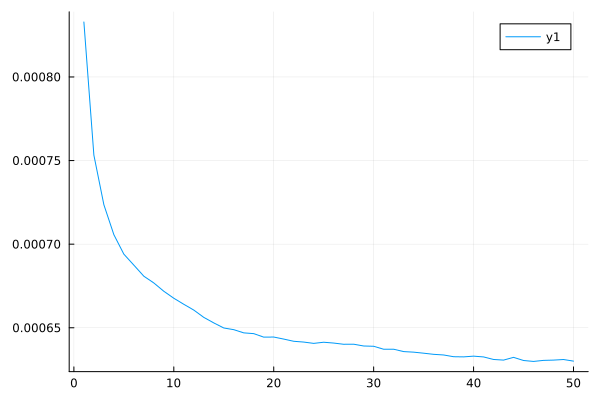

In [8]:
plot(ls1)

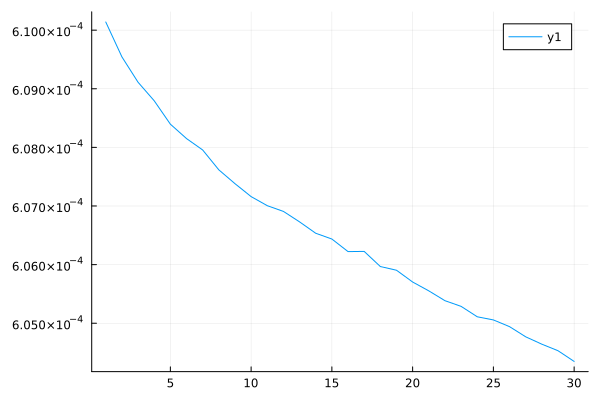

In [18]:
ls2 = train_and_monitor!(loss_uCNN1,uCNN1,batched_data_uCNN1,0.0002,30,data,data,1)
plot(ls2)

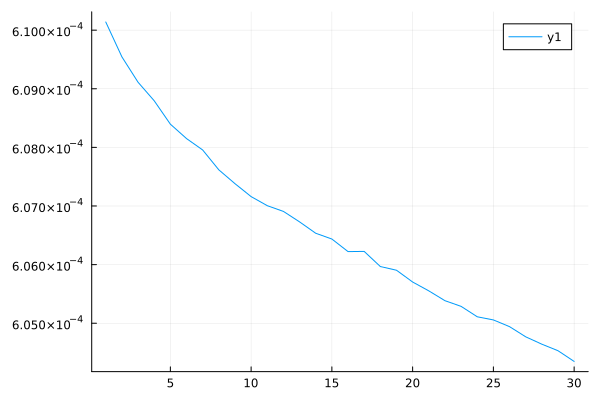

In [19]:
ls3 = train_and_monitor!(loss_uCNN1,uCNN1,batched_data_uCNN1,0.0004,10,data,data,1)
plot(ls3)

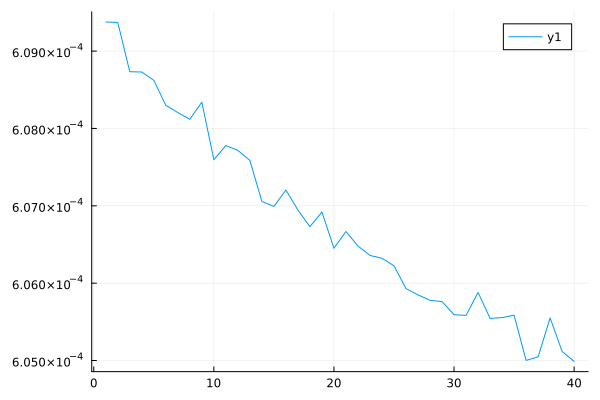

In [22]:
plot(ls4)

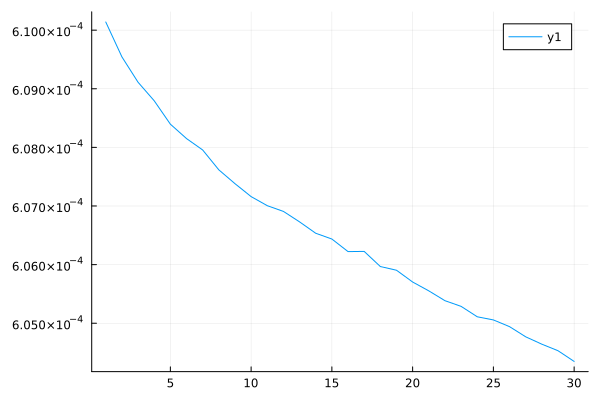

In [20]:
ls4 = train_and_monitor!(loss_uCNN1,uCNN1,batched_data_uCNN1,0.0004,40,data,data,1)
plot(ls4)

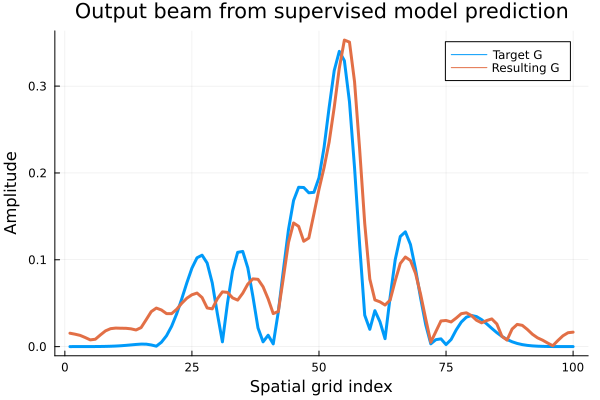

In [25]:
ampIn = randomHGAmplitude(nfft,Normal(),x-> (x==0 ? 1.0 : 0.01))
ampOut = randomHGAmplitude(nfft,Normal(),x-> (x==0 ? 1.0 : 0.1))
phi = uCNN1(convert.(Float32,reshape(vcat(ampIn,ampOut),2nfft,1,1)))[:,1]
#phi = uCNN1(vcat(ampIn,ampOut))
plot([ampOut,fftshift(abs.(ft*(ampIn .* exp.(2*pi*im*phi))/10))],labels=["Target G" "Resulting G"], linewidth=3, xlabel="Spatial grid index", ylabel="Amplitude",title="Output beam from supervised model prediction")

In [23]:
# Get the metric performance of the model
err = []
for i=1:1000
    ampIn = randomHGAmplitude(nfft,Normal(),x-> (x==0 ? 1.0 : 0.01))
    ampOut = randomHGAmplitude(nfft,Normal(),x-> (x==0 ? 1.0 : 0.1))
    phi = convert.(Float64,uCNN1(convert.(Float32,reshape(vcat(ampIn,ampOut),2nfft,1,1)))[:,1])
    append!(err,PRerror(ampIn,ampOut,phi,ft,shift=true))
end
mean(err),std(err)

(0.08088879120560455, 0.06979812161596892)

In [24]:
# Save the model
@save "uCNN1.bson" uCNN1